Practice with decision tree, implementation from scratch

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

In [8]:
class DecisionTreeNode:
    def __init__(self, X, y, feature_names, min_samples_leaf=5, max_depth=6, idxs=None, side=None):
        # print(f"\n=== New {side} Tree Node Initialization ===")
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.feature_names = feature_names
        
        if idxs is None: 
            idxs = np.arange(len(y))
            
        self.X, self.y, self.idxs = X, y, idxs
        self.n, self.c = len(idxs), X.shape[1]
        self.val = np.mean(y[idxs])
        self.best_score = float('inf')
        self.left = None
        self.right = None
        
        if self.max_depth > 0:
            self._insert_child_nodes()
    
    def _insert_child_nodes(self):
        for j in range(self.c):
            self._find_better_split(j)
        if self.is_leaf: 
            return
        
        x = self.X[self.idxs, self.split_feature_idx]
        left_idx = np.nonzero(x <= self.split_value)[0]
        right_idx = np.nonzero(x > self.split_value)[0]
        
        self.left = DecisionTreeNode(self.X, self.y, self.feature_names, 
                                   self.min_samples_leaf, self.max_depth-1, 
                                   self.idxs[left_idx], 'left')
        self.right = DecisionTreeNode(self.X, self.y, self.feature_names, 
                                    self.min_samples_leaf, self.max_depth-1, 
                                    self.idxs[right_idx], 'right')
    
    def _find_better_split(self, feat_idx):
        x = self.X[self.idxs, feat_idx]
        y = self.y[self.idxs]
        # print(f"\nInvestigating feature {self.feature_names[feat_idx]}")
        # print(f"Feature values range: {x.min():.3f} to {x.max():.3f}")
        # print(f"Number of unique values: {len(np.unique(x))}")
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]

        sum_y, n = y.sum(), len(y)
        sum_y_right, n_right = sum_y, n
        sum_y_left, n_left = 0., 0

        # best_score_for_feature = float('inf')
        # best_split_for_feature = None

        for i in range(0, self.n - self.min_samples_leaf):
            y_i, x_i, x_i_next = sort_y[i], sort_x[i], sort_x[i+1]
            sum_y_left += y_i
            sum_y_right -= y_i
            n_left += 1
            n_right -= 1
            if n_left < self.min_samples_leaf or x_i == x_i_next:
                continue
            score = -sum_y_left ** 2 / n_left - sum_y_right ** 2 / n_right + sum_y ** 2 / n
            # if score < best_score_for_feature:
            #     best_score_for_feature = score
            #     best_split_for_feature = (x_i + x_i_next)/2
            #     print(f"\nPotential split for {self.feature_names[feat_idx]}:")
            #     print(f"Split value: {best_split_for_feature:.3f}")
            #     print(f"Score: {score:.3f}")
            #     print(f"Left size: {n_left}, Right size: {n_right}")
            #     print(f"Left mean: {sum_y_left/n_left:.1f}, Right mean: {sum_y_right/n_right:.1f}")
        
            if score < self.best_score:
                self.best_score = score
                self.split_feature_idx = feat_idx
                self.split_value = (x_i + x_i_next) / 2
    
    def predict_row(self, row):
        if self.is_leaf:
            return self.val
        if row[self.split_feature_idx] <= self.split_value:
            return self.left.predict_row(row)
        else:
            return self.right.predict_row(row)
    
    @property
    def is_leaf(self):
        return self.best_score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}'
        s += f'; value:{self.val:0.2f}'
        if not self.is_leaf:
            split_feature_name = self.feature_names[self.split_feature_idx]
            s += f'; split: {split_feature_name} <= {self.split_value:0.3f}'
        return s

**Building xgboost from scratch using pandas and numpy :)**

implementation will also support user-defined custom objective functions, meaning that it can perform 
regression, classification, and whatever exotic learning tasks you can dream up, as long as you can 
write down a twice-differentiable objective function.

implement column subsampling myself

We are doing the exact tree-splitting algorithm. Other options are sparsity-aware method (used to handle
missing feature values) and the approximate method (used for scalability)


In [9]:
class DecisionTree:
    def __init__(self, min_samples_leaf=5, max_depth=6):
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.root = None
        
    def fit(self, X, y, feature_names=None):
        """Fit the decision tree to the data."""
        if feature_names is None:
            feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            
        self.feature_names = feature_names
        self.root = DecisionTreeNode(X, y, feature_names, self.min_samples_leaf, self.max_depth)

        return self
    def predict(self, X):
        # Convert DataFrame to numpy if needed
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
        return np.array([self.root.predict_row(row) for row in X])
    
    def print_tree(self, node=None, indent=""):
        """Print a visualization of the tree structure"""
        if node is None:
            node = self.root
            
        print(f"{indent}Node: {node}")
        if not node.is_leaf:
            print(f"{indent}├── Left: ", end="")
            self.print_tree(node.left, indent + "│   ")
            print(f"{indent}└── Right:", end="")
            self.print_tree(node.right, indent + "    ")

Now let's test the performance against sklearn's decision tree <br /> <br />
We'll use the diabetes data and california housing data

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

max_depth = 8
min_samples_leaf = 16

## DIABETES ##

X, y = load_diabetes(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

sk_tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)
print("DIABETES RESULTS")
print(f'scikit-learn MSE: {mean_squared_error(y_test, sk_pred):0.4f}')

feature_names = X_train.columns
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
t = DecisionTree(min_samples_leaf=min_samples_leaf, max_depth=max_depth)
t.fit(X_train, y_train, feature_names)
pred = t.predict(X_test)
print(f'from scratch MSE: {mean_squared_error(y_test, pred):0.4f}\n')

## CALI HOUSING ##

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)



sk_tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)

print("CALI HOUSING RESULTS")
print(f'scikit-learn MSE: {mean_squared_error(y_test, sk_pred):0.4f}')

feature_names = X_train.columns
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
t = DecisionTree(min_samples_leaf=min_samples_leaf, max_depth=max_depth)
t.fit(X_train, y_train, feature_names)
pred = t.predict(X_test)
print(f'from scratch MSE: {mean_squared_error(y_test, pred):0.4f}\n')


DIABETES RESULTS
scikit-learn MSE: 4422.5000
from scratch MSE: 4422.5000

CALI HOUSING RESULTS
scikit-learn MSE: 0.4133
from scratch MSE: 0.4133



Nice! Same error. However, I'm sure our method is much slower because of python. Let's explore!

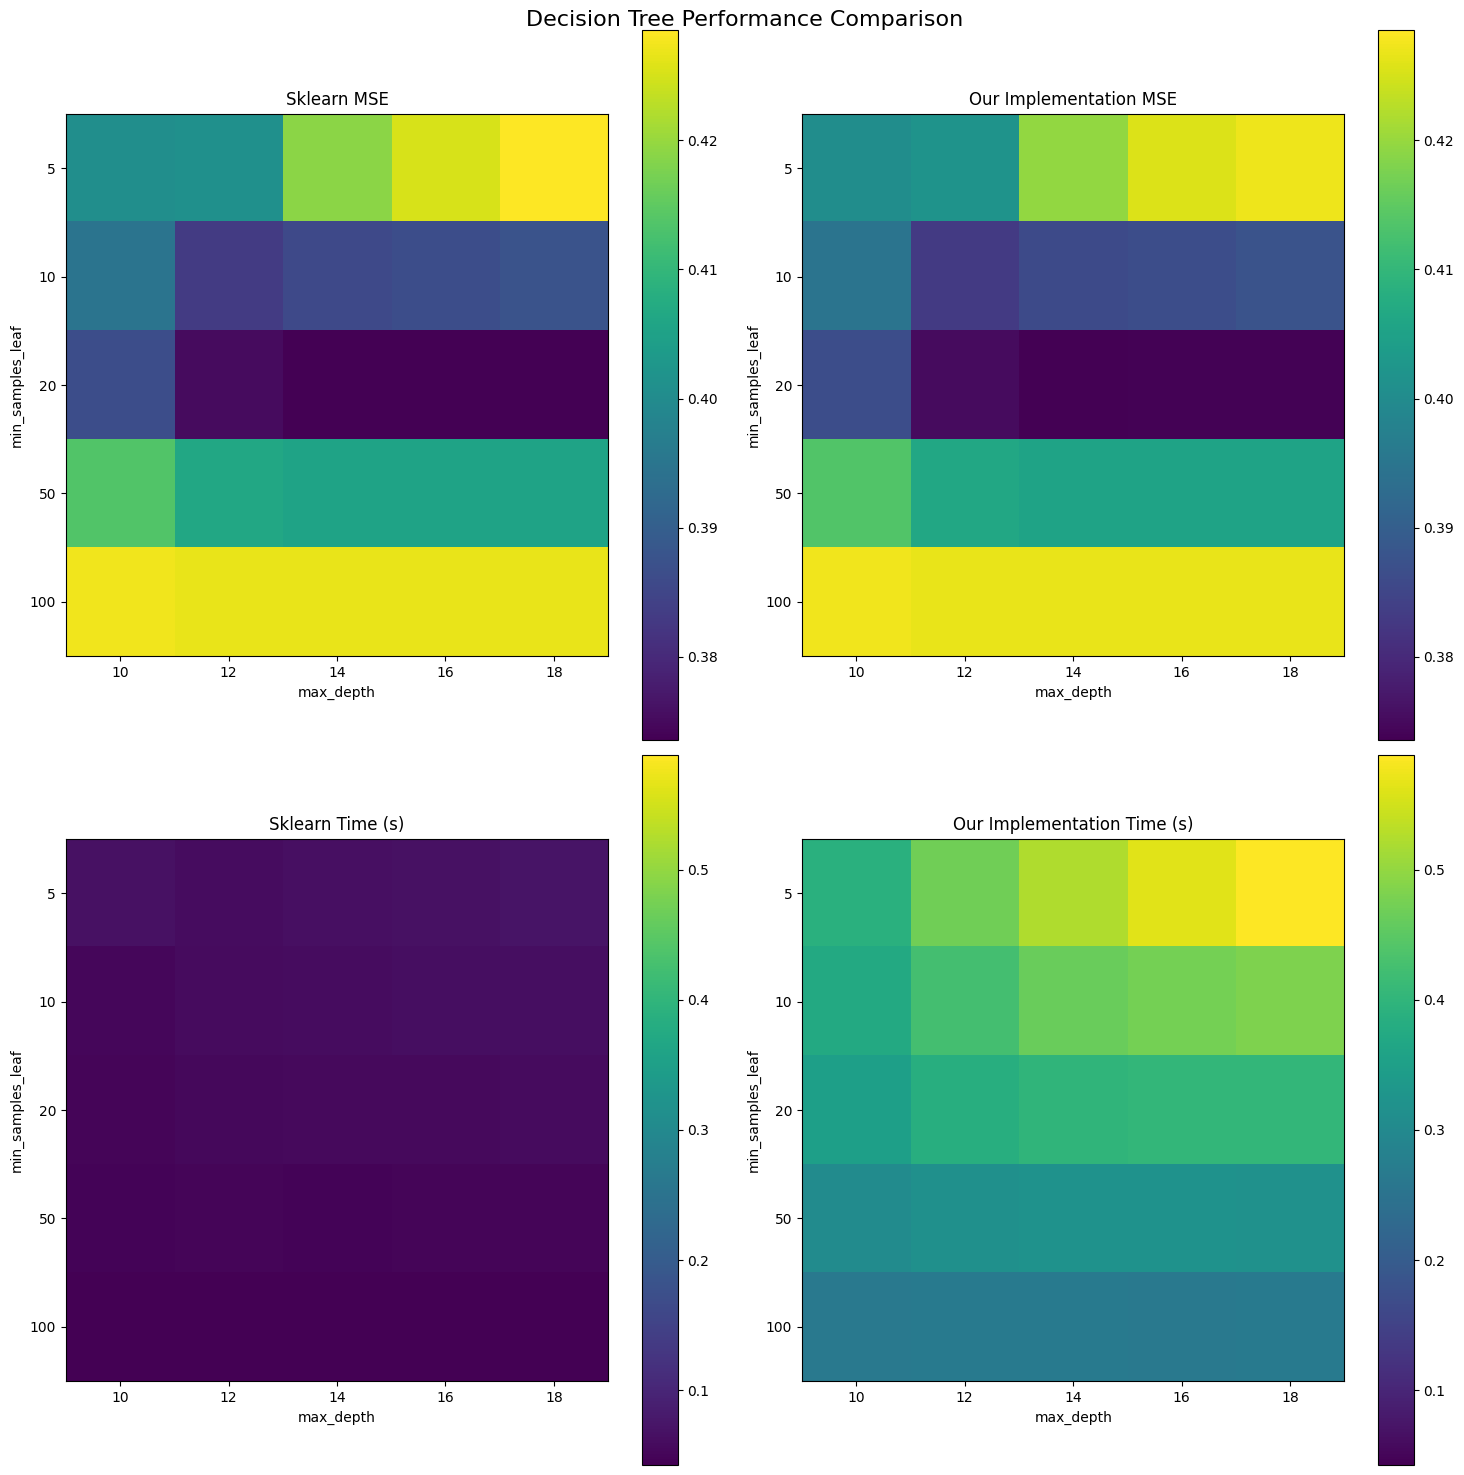


Best Parameters:
Sklearn - max_depth: 14, min_samples_leaf: 20
MSE: 0.3736, Time: 0.06s

Our Implementation - max_depth: 14, min_samples_leaf: 20
MSE: 0.3737, Time: 0.40s


In [19]:
import matplotlib.pyplot as plt
import time
import pandas as pd

# Load California Housing dataset
X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define parameter grids
max_depths = [10, 12, 14, 16, 18]
min_samples = [5, 10, 20, 50, 100]

# Create grid for plotting
depth_grid, samples_grid = np.meshgrid(max_depths, min_samples)
mse_grid_sk = np.zeros_like(depth_grid, dtype=float)
mse_grid_scratch = np.zeros_like(depth_grid, dtype=float)
time_grid_sk = np.zeros_like(depth_grid, dtype=float)
time_grid_scratch = np.zeros_like(depth_grid, dtype=float)

# Convert data to numpy arrays once
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()
feature_names = X_train.columns

# print("Starting grid search...")
for i, min_samples_leaf in enumerate(min_samples):
    for j, max_depth in enumerate(max_depths):
        # print(f"\nTesting max_depth={max_depth}, min_samples_leaf={min_samples_leaf}")
        
        # Sklearn
        start_time = time.time()
        sk_tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        sk_tree.fit(X_train, y_train)
        sk_pred = sk_tree.predict(X_test)
        sk_time = time.time() - start_time
        sk_mse = mean_squared_error(y_test, sk_pred)
        
        # Our implementation
        start_time = time.time()
        our_tree = DecisionTree(min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        our_tree.fit(X_train_np, y_train_np, feature_names)
        our_pred = our_tree.predict(X_test_np)
        our_time = time.time() - start_time
        our_mse = mean_squared_error(y_test, our_pred)
        
        # Store results
        mse_grid_sk[i, j] = sk_mse
        mse_grid_scratch[i, j] = our_mse
        time_grid_sk[i, j] = sk_time
        time_grid_scratch[i, j] = our_time
        
        # print(f"Sklearn - Time: {sk_time:.2f}s, MSE: {sk_mse:.4f}")
        # print(f"Scratch - Time: {our_time:.2f}s, MSE: {our_mse:.4f}")

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Decision Tree Performance Comparison', fontsize=16)

# Find global min/max for MSE and time for consistent color scales
vmin_mse = min(np.min(mse_grid_sk), np.min(mse_grid_scratch))
vmax_mse = max(np.max(mse_grid_sk), np.max(mse_grid_scratch))
vmin_time = min(np.min(time_grid_sk), np.min(time_grid_scratch))
vmax_time = max(np.max(time_grid_sk), np.max(time_grid_scratch))

# MSE plots
im1 = axes[0,0].imshow(mse_grid_sk, vmin=vmin_mse, vmax=vmax_mse)
axes[0,0].set_title('Sklearn MSE')
plt.colorbar(im1, ax=axes[0,0])

im2 = axes[0,1].imshow(mse_grid_scratch, vmin=vmin_mse, vmax=vmax_mse)
axes[0,1].set_title('Our Implementation MSE')
plt.colorbar(im2, ax=axes[0,1])

# Time plots
im3 = axes[1,0].imshow(time_grid_sk, vmin=vmin_time, vmax=vmax_time)
axes[1,0].set_title('Sklearn Time (s)')
plt.colorbar(im3, ax=axes[1,0])

im4 = axes[1,1].imshow(time_grid_scratch, vmin=vmin_time, vmax=vmax_time)
axes[1,1].set_title('Our Implementation Time (s)')
plt.colorbar(im4, ax=axes[1,1])

# Add labels
for ax in axes.flat:
    ax.set_xticks(np.arange(len(max_depths)))
    ax.set_yticks(np.arange(len(min_samples)))
    ax.set_xticklabels(max_depths)
    ax.set_yticklabels(min_samples)
    ax.set_xlabel('max_depth')
    ax.set_ylabel('min_samples_leaf')

plt.tight_layout()
plt.show()

# Print best parameters
sk_best_idx = np.unravel_index(np.argmin(mse_grid_sk), mse_grid_sk.shape)
our_best_idx = np.unravel_index(np.argmin(mse_grid_scratch), mse_grid_scratch.shape)

print("\nBest Parameters:")
print(f"Sklearn - max_depth: {max_depths[sk_best_idx[1]]}, min_samples_leaf: {min_samples[sk_best_idx[0]]}")
print(f"MSE: {mse_grid_sk[sk_best_idx]:.4f}, Time: {time_grid_sk[sk_best_idx]:.2f}s")

print(f"\nOur Implementation - max_depth: {max_depths[our_best_idx[1]]}, min_samples_leaf: {min_samples[our_best_idx[0]]}")
print(f"MSE: {mse_grid_scratch[our_best_idx]:.4f}, Time: {time_grid_scratch[our_best_idx]:.2f}s")

Wow! Our implementation is much slower! At least the errors are the same...